In [4]:
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F

import torch.distributions.multivariate_normal as mn
import math

import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf

from sklearn.decomposition import PCA

random_seed = 99
torch.manual_seed(random_seed)
#DEVICE = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
DEVICE = torch.device('cpu')

# BAGAN

In [5]:
def wflist(filename):
    wflist = []
    f = h5py.File(filename,'r')
    tp0 = np.array(f["raw"]["tp_0"])
    wf = np.array(f["raw"]["waveform"]["values"])
    tdrift = np.array(f["raw"]["dt"])
    avse = np.array(f["raw"]["A"]["E"])
    index = np.array(f["raw"]["index"])

    for i in range(len(tp0)):
        if np.isnan(tp0[i]):
            continue
        wflist.append({"wf":wf[i],
                       "t0":int(tp0[i]/16.0),
                       "tDrift":tdrift[i],
                       "avse": avse[i],
                       "index": index[i],
                    })
    return wflist

In [6]:
def wf_dataframe(wflist):
    wf = []
    t0 = []
    tDrift = []
    avse = []
    index = []
    for i in range(len(wflist)):
        wf.append(wflist[i]['wf'])
        t0.append(wflist[i]['t0'])
        tDrift.append(wflist[i]['tDrift'])
        avse.append(wflist[i]['avse'])
        index.append(wflist[i]['index'])

    wf = np.array(wf)
    t0 = np.array(t0)
    tDrift = np.array(tDrift)
    avse = np.array(avse)
    index = np.array(index)
    
    
    data = pd.DataFrame()
#     for i in range(wf.shape[1]):
#         tmp = []
#         for j in range(wf.shape[0]):
#             tmp.append(wf[j][i])
#         data['wf' + str(i)] = tmp

    A = ['wf'+str(i) for i in range (3748)]
    data = pd.DataFrame(wf, columns = A)
    data['t0'] = t0
    data['tDrift'] = tDrift
    data['avse'] = avse

    return data

In [7]:
filename_dep = '/Users/nzaretski/Desktop/gerda/w2022/ICPC/V05612B.lh5'

In [8]:
wflist_dep = wflist(filename_dep)
dep = wf_dataframe(wflist_dep)
#dep['label'] = 1

In [9]:
dep

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26345,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26330,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26324,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26324,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26341,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26249,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26280,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26288,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26309,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924


In [10]:
data = dep

In [11]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26345,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26330,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26324,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26324,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26341,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26249,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26280,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26288,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26309,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924


In [12]:
data.drop('avse', inplace = True, axis = 1)
data.drop('tDrift', inplace = True, axis = 1)
data.drop('t0', inplace = True, axis = 1)

In [13]:
data = data.reset_index()
data.drop(data.columns[[0]], axis  = 1, inplace = True)

In [14]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26343,26337,26340,26345,26357,26323,26326,26335,26340,26328
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26322,26341,26340,26330,26329,26328,26309,26293,26291,26285
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26331,26339,26332,26324,26311,26309,26310,26302,26302,26309
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26351,26340,26334,26324,26332,26333,26327,26320,26334,26331
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26343,26332,26334,26341,26334,26343,26347,26331,26321,26315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26287,26273,26255,26249,26239,26233,26246,26233,26229,26225
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26308,26312,26296,26280,26276,26276,26275,26267,26249,26232
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26292,26280,26282,26288,26290,26278,26270,26263,26254,26257
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26315,26287,26294,26309,26319,26322,26313,26303,26291,26279


In [15]:
arr1 = np.array(data)
arr1 = arr1.astype('float')
arr = arr1

# for i in range(arr1.shape[0]):
#     arr[i] = (arr1[i] - arr1[i].min())
#     arr[i] = arr[i] / arr[i].max()

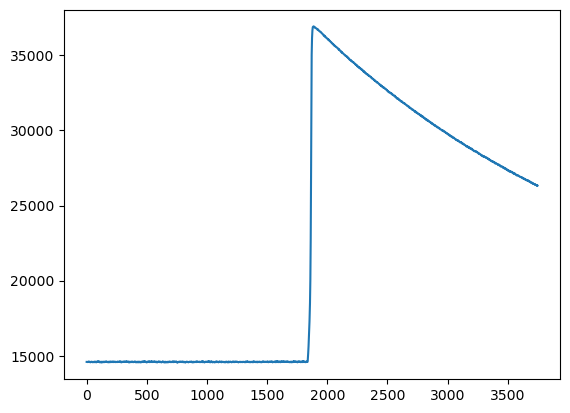

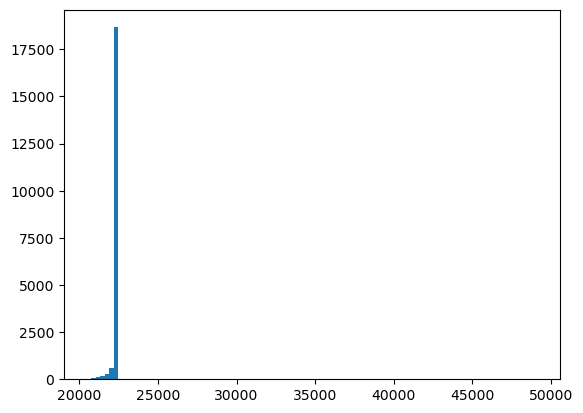

In [16]:
tmp_0 = []
for i in arr:
    tmp_0.append(i.max() - i.min())
plt.plot(arr[0])
plt.show()
plt.hist(tmp_0, bins=100)
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
arr = scaler.fit_transform(arr) #remove

pca = PCA(n_components=256)
arr = pca.fit_transform(arr)

In [18]:
train_data_length = arr.shape[0]
train_data = torch.zeros((train_data_length, arr.shape[1]))
train_data = torch.tensor(arr, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [ ]:
batch_size = 128

In [2]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

NameError: name 'torch' is not defined

## 1. Models

In [3]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 256

latent_dims = 32 
random_dim = latent_dims


In [19]:
class Discriminator(nn.Module):   ## changed
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.seq_len // 8, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 16, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return torch.sigmoid(output.squeeze(-1))

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.latent_dims = latent_dims
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False)
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

#  Minimax

In [21]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [22]:
epochs = 100

In [23]:
#autoenc
EPS = 1e-15
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)

G_losses = []
D_losses = []

random_dim = latent_dims
import time
start_time = time.time()

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)
        real_samples_labels = torch.ones((batch_size, 1))
        real_samples_labels = real_samples_labels.to(DEVICE)
        
        latent_space_samples = torch.randn((batch_size, random_dim))
        latent_space_samples = latent_space_samples.to(DEVICE)
        
        generated_samples = netG(latent_space_samples)
        
        generated_samples_labels = torch.zeros((batch_size, 1))
        generated_samples_labels = generated_samples_labels.to(DEVICE)
        
        all_samples = torch.cat((x, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        ## training the discriminator
        netD.zero_grad()
        output_discriminator = netD(all_samples)
        
        errD = criterion(output_discriminator, all_samples_labels)
        errD.backward()
        optimizerD.step()
        
        ## training the generator
        latent_space_samples = torch.randn(batch_size, random_dim)
        latent_space_samples = latent_space_samples.to(DEVICE)
        netG.zero_grad()
        generated_samples = netG(latent_space_samples)
        outputDG = netD(generated_samples)
        errG = criterion(outputDG, real_samples_labels) #########
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item()) 
        D_losses.append(errD.item())
    
        
        if (epoch % 5 == 0 and i == batch_size - 1):
                print(f"Epoch{epoch} Loss D.: {errD}" "||" 
                  f"Loss G.: {errG}")
                
    if (epoch == 0):
        print(round(time.time() - start_time, 2), ' seconds')
    
    if (epoch % 50 == 0):
        torch.save(netG.state_dict(), 'gen' +str(epoch) + '.pth')
        torch.save(netD.state_dict(), 'discr' +str(epoch) + '.pth')   
        

Epoch0 Loss D.: 0.4056819975376129||Loss G.: 0.5620157718658447
12.96  seconds
Epoch5 Loss D.: 0.15149816870689392||Loss G.: 0.47190961241722107
Epoch10 Loss D.: 0.07693244516849518||Loss G.: 0.4074220657348633
Epoch15 Loss D.: 0.04195230454206467||Loss G.: 0.3636561632156372
Epoch20 Loss D.: 0.02429843693971634||Loss G.: 0.3399727940559387
Epoch25 Loss D.: 0.014740332961082458||Loss G.: 0.3393405079841614
Epoch30 Loss D.: 0.00932976696640253||Loss G.: 0.2790414094924927
Epoch35 Loss D.: 0.005520385690033436||Loss G.: 0.27428117394447327
Epoch40 Loss D.: 0.0035327777732163668||Loss G.: 0.25701141357421875
Epoch45 Loss D.: 0.0022581256926059723||Loss G.: 0.2493588626384735
Epoch50 Loss D.: 0.001467651454731822||Loss G.: 0.26524314284324646
Epoch55 Loss D.: 0.0009528800146654248||Loss G.: 0.250569611787796
Epoch60 Loss D.: 0.0006207162514328957||Loss G.: 0.2304774820804596
Epoch65 Loss D.: 0.0004222133429720998||Loss G.: 0.24168486893177032
Epoch70 Loss D.: 0.0002701047924347222||Loss G.

In [24]:
torch.save(netG.state_dict(), 'generator.pth')

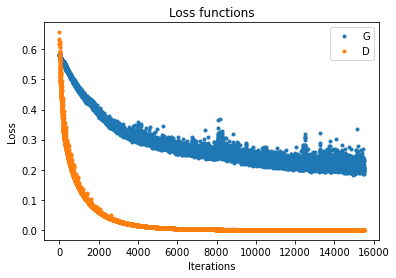

In [25]:
fig = plt.figure()
plt.plot(G_losses, '.', label='G')
plt.plot(D_losses, '.',  label='D')
plt.title('Loss functions')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

# Check

In [26]:
netG = Generator() 
netG.load_state_dict(torch.load("generator.pth"))

<All keys matched successfully>

In [27]:
x = torch.randn(10, 32)

In [28]:
gen = netG(x).detach()
gen = pca.inverse_transform(gen) # back to 3748
gen = scaler.inverse_transform(gen) # back to normal

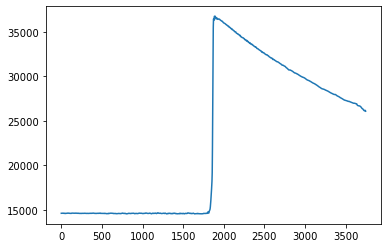

In [29]:
plt.plot(gen[0])

In [30]:
gen[0] - gen[1]

array([  7.82695677,   7.82695677,   8.08723448, ..., -23.53976586,
       -28.11837873, -26.77089934])